In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json


In [14]:
def show_images(images, titles):
    n = len(images)
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [15]:
coco = COCO('../coco2014/annotations/person_keypoints_train2014.json')


loading annotations into memory...
Done (t=6.83s)
creating index...
index created!


In [16]:
movenet = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-lightning/4")

In [17]:
def is_full_body(ann, min_keypoints=17):
    keypoints = ann['keypoints']
    num_visible = sum(1 for i in range(0, len(keypoints)) if keypoints[i] > 0)  # Count visible keypoints
    if num_visible < min_keypoints:
        return False  # Not all keypoints are visible
    
    bbox = ann['bbox']
    bbox_aspect_ratio = bbox[3] / bbox[2]  
    if bbox_aspect_ratio < 1.5:  # Threshold for a standing full-body shot
        return False
    
    return True

In [18]:
image_dir = "../coco2014/images/train2014"

human_images_anns = []

human_image_ids = set()
for ann in coco.anns.values():
    if ann['category_id'] == 1 and ann['iscrowd'] == 0 and is_full_body(ann,17) == True: #human, not a crowd, displays full body
        human_image_ids.add(ann['image_id'])
        human_images_anns.append(ann)
count = 0
human_image_paths = []
for img_id in human_image_ids:
    if(count < 200):
        img_info = coco.loadImgs(img_id)[0]
        img_path = f"{image_dir}/{img_info['file_name']}"
        human_image_paths.append(img_path)
        count+=1

print(len(human_image_paths))

200


In [19]:
keypoint_names = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder',
                  'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
                  'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

connections = [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9), (6, 8), (8, 10),
               (5, 6), (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)]

def detect_pose_static(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.medianBlur(v,3)
    v = cv2.equalizeHist(v)
    hsv_image = cv2.merge([h, s, v])
    final_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

    image_resized = tf.image.resize_with_pad(tf.expand_dims(final_image, axis=0), 192, 192) #192 for lightning
    image_np = image_resized.numpy().astype(np.int32)
    outputs = movenet.signatures["serving_default"](tf.constant(image_np))
    keypoints = outputs['output_0'].numpy()

    original_image_resized = tf.image.resize_with_pad(tf.expand_dims(image, axis=0), 192, 192)
    original_image_np = original_image_resized.numpy().astype(np.int32)
    outputs = movenet.signatures["serving_default"](tf.constant(original_image_np))
    original_keypoints = outputs['output_0'].numpy()

    return keypoints,original_keypoints

def visualize_pose_static(image_path, keypoints, original_keypoints):
    image = cv2.imread(image_path)
    image_original = cv2.imread(image_path)
    keypoints = np.array(keypoints)
    original_keypoints = np.array(original_keypoints)
    if keypoints.shape == (1, 1, 17, 3):
        keypoints = keypoints[0, 0]
        for kp in keypoints:
            x = int(kp[1] * image.shape[1])
            y = int(kp[0] * image.shape[0])
            cv2.circle(image, (x, y), 12, (255, 0, 0), -1)  # Increase thickness and change color to blue
        for connection in connections:
            start_point = (int(keypoints[connection[0], 1] * image.shape[1]),
                           int(keypoints[connection[0], 0] * image.shape[0]))
            end_point = (int(keypoints[connection[1], 1] * image.shape[1]),
                         int(keypoints[connection[1], 0] * image.shape[0]))
            cv2.line(image, start_point, end_point, (0, 0, 255), 8)  # Increase thickness and change color to red
        
        original_keypoints = original_keypoints[0, 0]
        for kp in original_keypoints:
            x = int(kp[1] * image_original.shape[1])
            y = int(kp[0] * image_original.shape[0])
            cv2.circle(image_original, (x, y), 12, (255, 0, 0), -1)  # Increase thickness and change color to blue
        for connection in connections:
            start_point = (int(original_keypoints[connection[0], 1] * image_original.shape[1]),
                           int(original_keypoints[connection[0], 0] * image_original.shape[0]))
            end_point = (int(original_keypoints[connection[1], 1] * image_original.shape[1]),
                         int(original_keypoints[connection[1], 0] * image_original.shape[0]))
            cv2.line(image_original, start_point, end_point, (0, 0, 255), 8)  # Increase thickness and change color to red
        show_images([image_original,image],["Predicted Annotations without Processing","Predicted Annotations after Processing"])
    else:
        print("Unexpected shape of keypoints array:", keypoints.shape)

In [20]:
def format_coco_results(human_image_paths, predictions, coco):
    results = []
    for image_path, pred in zip(human_image_paths, predictions):
        img_id = int(image_path.split("_")[-1].split(".")[0])  # Extract COCO image ID
        keypoints = pred[0, 0, :, :]  # Shape: [17, 3]
        
        # Convert normalized keypoints to absolute image coordinates
        image = cv2.imread(image_path)
        h, w, _ = image.shape
        formatted_keypoints = []
        for kp in keypoints:
            x, y, confidence = float(kp[1] * w), float(kp[0] * h), float(kp[2])
            formatted_keypoints.extend([x, y, 2 if confidence > 0.5 else 0])  # Use confidence threshold
        
        results.append({
            "image_id": img_id,
            "category_id": 1,  # Category for 'person'
            "keypoints": formatted_keypoints,
            "num_keypoints": len(formatted_keypoints)/3,
            "score": float(keypoints[:, 2].mean())
        })
    return results

for ann in coco.anns.values():
    if 'num_keypoints' not in ann:
        ann['num_keypoints'] = 17
    if 'keypoints' not in ann: 
        ann['keypoints'] = []

# Detect poses and format results
predictions_equalized = []
predictions_unequalized = []
for static_image_path in human_image_paths:
    static_keypoints_equalized, static_keypoints_unequalized = detect_pose_static(static_image_path)
    predictions_equalized.append(static_keypoints_equalized)
    predictions_unequalized.append(static_keypoints_unequalized)


coco_results = format_coco_results(human_image_paths, predictions_equalized, coco)
results_path_equalized = "pose_results_equalized.json"
with open(results_path_equalized, 'w') as f:
    json.dump(coco_results, f, indent=2)

# Load results and evaluate
coco_dt = coco.loadRes(results_path_equalized)
coco_eval = COCOeval(coco, coco_dt, "keypoints")
coco_eval.evaluate()
coco_eval.accumulate()
print("Evaluation for Equalized Images:")
coco_eval.summarize()

coco_results = format_coco_results(human_image_paths, predictions_unequalized, coco)
results_path_unequalized = "pose_results_unequalized.json"
with open(results_path_unequalized, 'w') as f:
    json.dump(coco_results, f, indent=2)

coco_dt = coco.loadRes(results_path_unequalized)
coco_eval = COCOeval(coco, coco_dt, "keypoints")
coco_eval.evaluate()
coco_eval.accumulate()
print("Evaluation for Unequalized Images:")
coco_eval.summarize()

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=8.60s).
Accumulating evaluation results...
DONE (t=0.47s).
Evaluation for Equalized Images:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.001
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ Io

In [21]:
def min_max_normalize(lst):
    arr = np.array(lst)
    return (arr - arr.min()) / (arr.max() - arr.min())

def calculateMSE(MSE_list, human_images_anns,results_path):
    with open(results_path, 'r') as f:
        results = json.load(f)
    for ann in human_images_anns: 
        count = 0
        kp = ann['keypoints']
        for i in range(0,len(kp)-1,2):
            x_err = kp[i] - results[count]["keypoints"][i]
            y_err = kp[i+1] - results[count]["keypoints"][i+1]
            MSE_list.append(x_err**2 + y_err**2)
            count+=1  
    MSE_list = min_max_normalize(MSE_list)
    return np.mean(MSE_list)

MSE_list_equalized = []
MSE_list_unequalized = []

print("Average Mean Squared Error for Unequalized Images:")
print(calculateMSE(MSE_list_unequalized,human_images_anns,results_path_unequalized))
print("Average Mean Squared Error for Equalized Images:")
print(calculateMSE(MSE_list_equalized,human_images_anns,results_path_equalized))



Average Mean Squared Error for Unequalized Images:
0.13982824609472194
Average Mean Squared Error for Equalized Images:
0.14172912214194563


In [22]:
#for static_image_path in human_image_paths:
    #print(static_image_path)
    #static_keypoints,original_static_keypoints = detect_pose_static(static_image_path)
    #visualize_pose_static(static_image_path, static_keypoints, original_static_keypoints)

[[193 191 188 ... 189 189 188]
 [194 192 192 ... 189 187 187]
 [194 193 193 ... 188 187 189]
 ...
 [120 138 141 ... 252 255 254]
 [121 135 131 ... 252 255 253]
 [124 133 132 ... 248 255 252]]


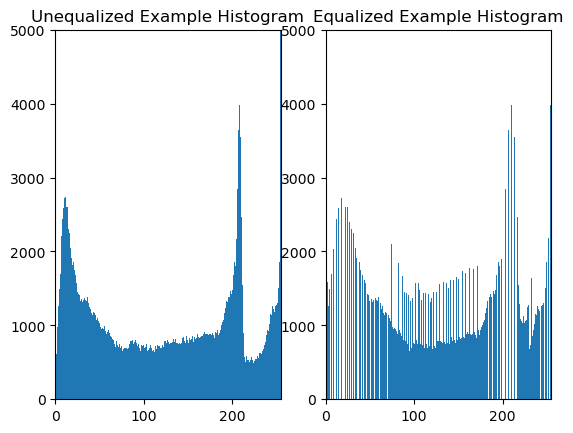

In [ ]:
def get_equalized_histogram(human_image_paths):
    example_image = cv2.imread(human_image_paths[0])
    hsv = cv2.cvtColor(example_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    print(v)
    equalized_v = cv2.equalizeHist(v)
    fig, ax = plt.subplots(nrows=1, ncols=2)    
    ax[0].hist(v.flatten(), 255)
    ax[1].hist(equalized_v.flatten(),255)
    ax[0].set_title("Unequalized Example Histogram")
    ax[1].set_title("Equalized Example Histogram")

    for a in ax:
        a.set_xlim([0,255])
        a.set_ylim([0,5000])
    plt.show()    

get_equalized_histogram(human_image_paths)
